# User Churn Prediction(DePaul University: ShikeLi)

Machine learning and big data processing will affect a wide range of industries, including the financial services industry, consulting sector and others. In order to increase my data analysis skills, I learned machine learning deeply. User analysis and Churn Prediction is one of the projects I did.

## Contents

<ul>
<li>[Part 1: Data Exploration](#Part-1:-Data-Exploration)
<li>[Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
<li>[Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
<li>[Part 4: Feature Selection](#Part-4:-Feature-Selection)
<li>[Part 5: Use Probabilities as Prediction Results](#Part-5:-Use-Probabilities-as-Prediction-Results)
</ul>

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [48]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import time
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
churn_df = pd.read_csv('data/churn.all')

In [3]:
print ("Num of rows: " + str(churn_df.shape[0])) # row count
print ("Num of columns: " + str(churn_df.shape[1])) # col count

Num of rows: 5000
Num of columns: 21


### Part 1.2: Data cleaning

Remove Extra Whitespace
view element and check if we need to clean it.

In [8]:
churn_df['voice_mail_plan'][0]

' yes'

In [9]:
churn_df['intl_plan'][0]

' no'

In [11]:
churn_df['churned'][0]

' False.'

In [7]:
#None Check
churn_df[churn_df.isna().any(axis=1)]

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned


In [4]:
#map function can help us use one method to clean our raw data
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].map(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].map(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].map(lambda x: x.strip())

### Part 1.3:  Understand the features

We can use plot and dataframe to check data.
We can also analyze pearson correlation
Using some package, we can show distribution and scattor plot together.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
#using pairplot, we can see several columns' correlation and data density distribution
#First, we can choose several columns
churn_df.columns

Index(['state', 'account_length', 'area_code', 'phone_number', 'intl_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churned'],
      dtype='object')

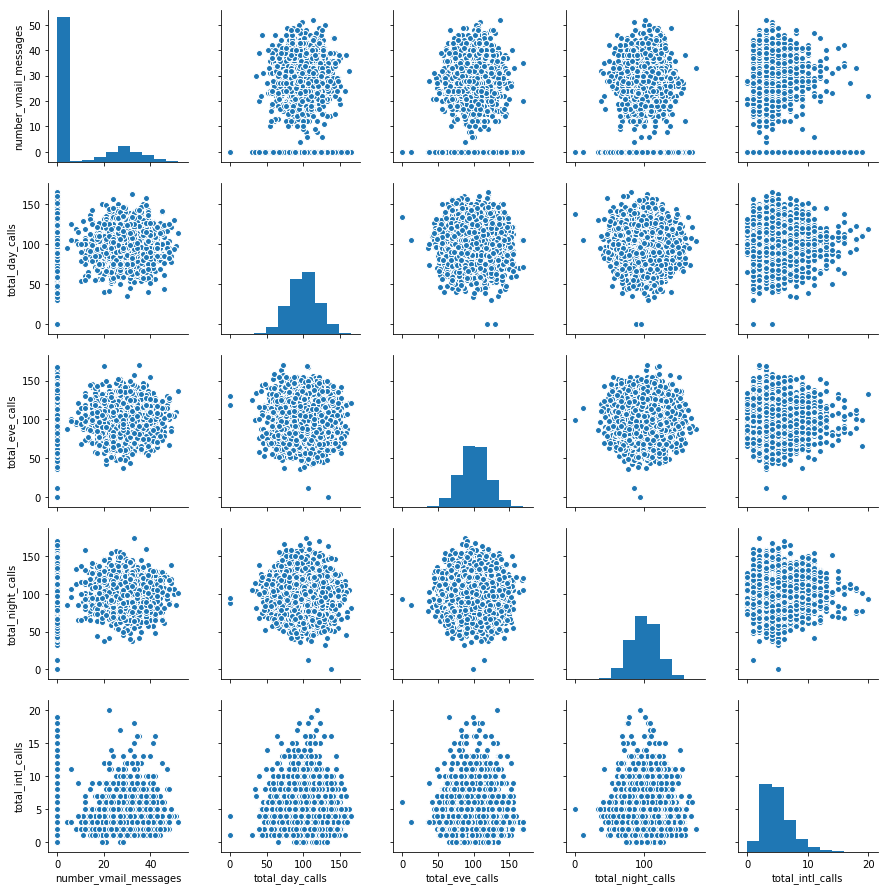

In [10]:
#For example, we have interest in 'number_vmail_messages','total_day_calls','total_eve_calls',
#'total_night_calls', 'total_intl_calls'
sb.pairplot(churn_df[['number_vmail_messages','total_day_calls','total_eve_calls',\
                      'total_night_calls', 'total_intl_calls']])

Conclusion: From above, we can find Voicemail and International Call are skewed data. Imbalanced data may skewed our model. We should judge the raw data using domain knowledge.

We can use heatmap visualize pearson correlation coefficient. Actually, graph below display a bad linear relationship between variables. Almost all of them are close to 0. But, *minutes and *charge have pretty high correlation coefficient. It's intuitive. Low correlation doesn't mean we cannot predict binary variable.

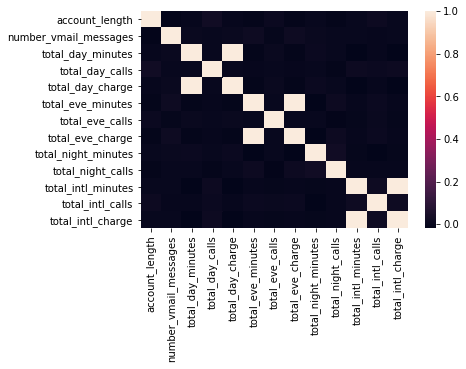

In [11]:
corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()

sb.heatmap(corr, )

# Part 2: Feature Preprocessing

In [12]:
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [18]:
# Get ground truth data
y = np.where(churn_df['churned'] == 'True.',1,0)
# Drop some useless columns, like categorical data, we need to do one-hot encoding
to_drop = ['state','area_code','phone_number','churned']
churn_feat_space = churn_df.drop(to_drop, axis=1)# get predictors
# yes and no have to be converted to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

In [21]:
#Now I want to bring back categorical column state to help us predict
churn_feat_space = pd.concat([churn_df['state'], churn_feat_space], axis = 1)
churn_feat_space_final = pd.get_dummies(churn_feat_space, columns = ['state'])

In [25]:
# Converts data frame to its Numpy-array representation.
X = churn_feat_space_final.as_matrix().astype(np.float)

In this block, we can use StandardScaler class to normalize our data so that we can compare them conveniently.
Standardization of a dataset is a common requirement for many machine learning estimators: especially for randomForest. For example House price would be always more important than monthly salary if we didn't normalize the raw data.
 

In [26]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))#double check the value of column 'churned'

Feature space holds 5000 observations and 68 features
Unique target labels: [0 1]


# Part 3: Model Training and Result Evaluation

### Part 3.1: K-fold Cross-Validation

Cross-Validation can help us determine which model we should use if we have several model candidates.

In [27]:
from sklearn.cross_validation import KFold
#This program does 5-fold. It saves the result at each time as different parts of y_pred. 
#In the end, it returns the y_pred as the result of all the five 5-fold.
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    clf = clf_class(**kwargs)
    # Iterate through folds
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]     
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Part 3.2: Run Supervised Learning Models and Calculate Accuracy

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred) # NumPy interpretes True and False as 1. and 0.

LR_CV_result = run_cv(X,y,LogisticRegression)
RF_CV_result = run_cv(X,y,RandomForestClassifier)
KNN_CV_result = run_cv(X,y,KNeighborsClassifier) #Default: n_neighbors=5
SVM_CV_result = run_cv(X, y, SVC)

In [32]:
print ("Logistic Regression (L2 is default): " + str(accuracy(y, LR_CV_result)))
print ("Random forest: " + str(accuracy(y, RF_CV_result)))
print ("K-nearest-neighbors: " + str(accuracy(y, KNN_CV_result)))
print ("SVM: " + str(accuracy(y, SVM_CV_result)))

Logistic Regression (L2 is default): 0.8644
Random forest: 0.934
K-nearest-neighbors: 0.8644
SVM: 0.88


From above, we can see random forest has strong performance. It uses several tree and bagging method to avoid overfitting problem. Usually SVM is also good at classification problem. But, randomforest can beat SVM on speed.

### Part 3.3: Use Grid Search to Find Optimal Parameters

#### Part 3.3.1: Find Optimal Parameters - LogisticRegression

Using above cross validation, we should choose RandomForest and SVM. Now we can tune these two model, and make it more efficient. But, here I did tuning for all models.

In [49]:
def print_grid_search_metrics(gs, parameters):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [50]:
st = time.time()
from sklearn.grid_search import GridSearchCV
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5, verbose=1, refit=False)
Grid_LR.fit(X, y)
ed = time.time()
print('Grid Search for Logistic Regression ', ed-st, ' seconds.')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Grid Search for Logistic Regression  8.293986082077026  seconds.


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    8.3s finished


In [51]:
print_grid_search_metrics(Grid_LR, parameters)

Best score: 0.864
Best parameters set:
	C: 1
	penalty: 'l1'


#### Part 3.3.2: Find Optimal Parameters: KNN

In [52]:
from sklearn.grid_search import GridSearchCV
st = time.time()
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5, verbose=1, refit=False)
Grid_KNN.fit(X, y)
ed = time.time()
print('Grid Search for KNN ', ed-st, ' seconds.')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Grid Search for KNN  4.980277061462402  seconds.


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.0s finished


In [53]:
print_grid_search_metrics(Grid_KNN, parameters)

Best score: 0.865
Best parameters set:
	n_neighbors: 5


#### Part 3.3.3: Find Optimal Parameters: RandomForest

In [54]:
from sklearn.grid_search import GridSearchCV
st = time.time()
parameters = {
    'criterion' : ('gini', 'entropy'),
    'max_depth' : (5, 7, 8, 10)
}
Grid_rf = GridSearchCV(RandomForestClassifier(), parameters, cv = 5, verbose = 1, refit = False)
Grid_rf.fit(X, y)
ed = time.time()
print('Grid Search for RandomeForest ', ed-st, ' seconds.')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Grid Search for RandomeForest  1.7250239849090576  seconds.


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.7s finished


In [55]:
print_grid_search_metrics(Grid_rf, parameters)

Best score: 0.926
Best parameters set:
	criterion: 'entropy'
	max_depth: 10


#### Part 3.3.4: Find Optimal Parameters: SVM

In [56]:
from sklearn.grid_search import GridSearchCV
st = time.time()
parameters = {
    'gamma' : (0.001, 0.01, 0.1, 1, 10, 100),
    'C' : (0.01, 0.1, 1, 5, 10)
}
Grid_SVM = GridSearchCV(SVC(), parameters, cv = 5, verbose = 1, refit = False)
Grid_SVM.fit(X, y)
ed = time.time()
print('Grid Search for SVM ', ed-st, ' seconds.')

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Grid Search for SVM  169.39801812171936  seconds.


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.8min finished


In [58]:
print_grid_search_metrics(Grid_SVM, parameters)

Best score: 0.902
Best parameters set:
	C: 10
	gamma: 0.01


Now, we can find the svm model is very slow. The time used is 169/1.7 = 100 times compared to RandomForest.

### Part 3.4: Calculate Confusion Matrix (Precision, Recall, Accuracy)

In [63]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print (classifier)
    print ("Accuracy is " + str(accuracy))
    print ("Precision is " + str(precision))
    print ("Recall is " + str(recall))

def draw_confusion_matrices(confusion_matricies):
    class_names = ['No_Churn','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111) #assign canvas
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Ground Truth')
        plt.show()

Random Forest
Accuracy is 0.934
Precision is 0.9333333333333333
Recall is 0.5742574257425742


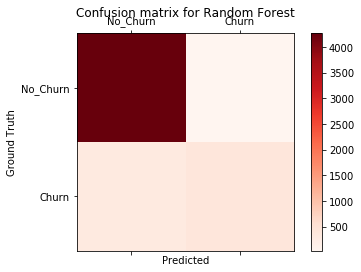

K-Nearest-Neighbors
Accuracy is 0.8644
Precision is 0.6435643564356436
Recall is 0.09193776520509193


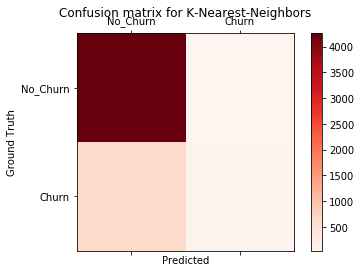

Logisitic Regression
Accuracy is 0.8644
Precision is 0.5498281786941581
Recall is 0.2263083451202263


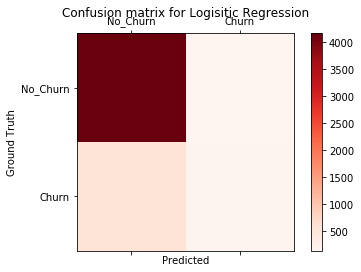

SVM
Accuracy is 0.88
Precision is 0.8590604026845637
Recall is 0.18104667609618105


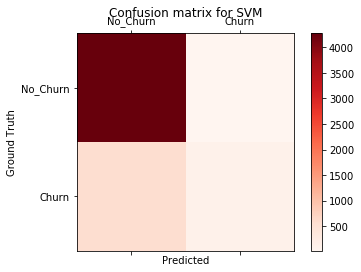

In [64]:
%matplotlib inline
y = np.array(y)
confusion_matrices = [
    ("Random Forest", confusion_matrix(y,RF_CV_result)),
    ("K-Nearest-Neighbors", confusion_matrix(y,KNN_CV_result)),
    ("Logisitic Regression", confusion_matrix(y,LR_CV_result)),
    ("SVM", confusion_matrix(y, SVM_CV_result))
]

draw_confusion_matrices(confusion_matrices)

# Part 4: Feature Selection

### Part 4.1:  Logistic Regression Model - Feature Selection Discussion 

The corelated features that we are interested in: (total_day_minutes, total_day_charge), (total_eve_minutes, total_eve_charge), (total_intl_minutes, total_intl_charge).

#### Part 4.1.1 - Compare Feature Coefficients

In [66]:
LRmodel_l1 = LogisticRegression(penalty="l1", C = 1.0)
LRmodel_l1.fit(X, y)
print ("Logistic Regression (L1) Coefficients")
for v,k in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), \
                      churn_feat_space.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (k + ": " + str(v))


Logistic Regression (L1) Coefficients
intl_plan: -0.8706
total_intl_charge: 0.6877
account_length: 0.6468
number_vmail_messages: 0.4265
voice_mail_plan: 0.4
total_day_calls: 0.3193
total_day_charge: 0.2112
total_intl_minutes: -0.1669
total_intl_calls: 0.1651
total_eve_calls: 0.1605
total_eve_charge: 0.1551
total_night_charge: 0.0806
number_customer_service_calls: -0.0747
state: 0.0609
total_day_minutes: 0.0583
total_night_calls: 0.0548
total_night_minutes: -0.0417
total_eve_minutes: -0.0248


'L1' Penalty is Lasso regression, it should keep only for high correlated variables, the coefficient for others will be approching to zero. In here, total_eve_minutes is almost zero, it has high correlation with total_eve_calls. But, sometime it this effect is not stable. For Rige Resssion, it is more stable to make the coefficients be same for high correlated variables.

### Part 4.2:  Random Forest Model - Feature Importance Discussion

In [67]:
forest = RandomForestClassifier(criterion = 'entropy', max_depth = 10)
forest.fit(X, y)
importances = forest.feature_importances_
# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for v,k in sorted(zip(map(lambda x: round(x, 4), importances), churn_feat_space.columns), reverse=True):
    print (k + ": " + str(v))

Feature importance ranking by Random Forest Model:
number_vmail_messages: 0.2171
total_intl_charge: 0.1334
total_day_calls: 0.1054
account_length: 0.0773
total_day_charge: 0.0613
total_eve_calls: 0.0494
total_eve_charge: 0.0335
total_intl_calls: 0.0331
total_intl_minutes: 0.0327
total_night_charge: 0.0326
total_night_calls: 0.0319
voice_mail_plan: 0.0303
intl_plan: 0.0259
state: 0.0252
total_day_minutes: 0.0235
total_eve_minutes: 0.0154
total_night_minutes: 0.014
number_customer_service_calls: 0.0008


For RandomForest, we don't have coefficients. But, we can get the feature importance, it means which one can impact prediction results most. Here, we can see the number of voice mail is most important.

# Part 5: Use Probabilities as Prediction Results

Basically, every model is trying its best to generate distribution for dependent variable. As an Data Scientist, we must get used to set a better threshold so that we won't missunderstand our model.
RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

In [68]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

Result Evaluation: Use the ground truth probability to compare with our probability prediction results.

In [83]:
from collections import defaultdict
true_prob = defaultdict(float)
pred_prob = run_prob_cv(X, y, RandomForestClassifier, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = (y == 1)
counts = pd.value_counts(pred_churn)
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])#The point is here
true_prob = pd.Series(true_prob)

In [97]:
EvaResults = pd.concat([counts,true_prob], axis=1).reset_index()
EvaResults.columns = ['pred_prob', 'count', 'true_prob']
EvaResults.sort_values(by = 'pred_prob')

,pred_prob,count,true_prob
0,0.0,2424,0.024340
1,0.1,1206,0.036484
2,0.2,428,0.067757
3,0.3,268,0.160448
4,0.4,133,0.360902
7,0.5,103,0.708738
5,0.6,127,0.858268
6,0.7,114,0.947368
8,0.8,89,0.977528
9,0.9,74,0.986486


Now, we can find the threshold for RandomForest should be 0.4. That means, we can mark the account will highly churn if the prediction probability is greater than or equal 0.4.